In [1]:
import pennylane as qml
from pennylane import numpy as np

In [2]:
class MyDevice(qml.QubitDevice):
    name = 'Clifford_T_device'
    short_name = "custom.qubit"
    pennylane_requires = ">=0.23"
    version = "0.0.1"
    author = "Maurice"
    # Here, I define the desired gate set to be used
    operations = {"H", "S", "CNOT", "T", "RZ"}
    observables = {"PauliX", "PauliZ"}

    def __init__(self, num_wires):
        super().__init__(wires=num_wires, shots=None)

        # create the initial state
        self._state = np.array([1, 0])

        # create a variable for future copies of the state
        self._pre_rotated_state = None

    @property
    def state(self):
        return self._pre_rotated_state

    @classmethod
    def capabilities(cls):
        capabilities = super().capabilities().copy()
        capabilities.update(
            returns_state=True,
            supports_finite_shots=False,
            supports_tensor_observables=False
        )
        return capabilities

    def apply(self, operations, rotations=None, **kwargs):
        for op in operations:
            # We update the state by applying the matrix representation of the gate
            self._state = qml.matrix(op) @ self._state

        # store the pre-rotated state
        self._pre_rotated_state = self._state.copy()

        # apply the circuit rotations
        for rot in rotations or []:
            self._state = qml.matrix(rot) @ self._state

    def analytic_probability(self, wires=None):
        if self._state is None:
            return None

        real = self._real(self._state)
        imag = self._imag(self._state)
        prob = self.marginal_prob(real ** 2 + imag ** 2, wires)
        return prob

    def reset(self):
        """Reset the device"""
        self._state = np.array([1, 0])

In [14]:
#4 dim evolve function 
def evolve_circuit_4(pstring, theta):
    if len(pstring) <=4:
        b0 = pstring.count("0")
        b1 = pstring.count("1")
        b2 = pstring.count("2")
        b3 = pstring.count("3")

        if b0+b1+b2+b3 ==0:
            w0 = pstring[0]
            w1 = pstring[1]
            w2 = pstring[2]
            w3 = pstring[3]
            pstring = f"{w0}0{w1}1{w2}2{w3}3"
    n = int(len(pstring)/2)
    
    evolve_wire = 0
    basis = []
    for i in range(0, 2*n, 2):
        if pstring[i] == "I":
            continue
        basis.append((pstring[i], pstring[i+1]))
    n = len(basis)
    # axis
    for axis, wire in basis:
        if axis =="X":
            qml.Hadamard(wire)
        elif axis =="Y":
            qml.Hadamard(wire)
            qml.S(wire)
    # Entangle
    if n ==2:
        n1 = basis[0][1]
        n2 = basis[1][1]
        qml.CNOT(wires=[n1, n2])
        evolve_wire = n2
    elif n==3:
        n1 = basis[0][1]
        n2 = basis[1][1]
        n3 = basis[2][1]

        qml.CNOT(wires=[n1, n2])
        qml.CNOT(wires=[n2, n3])
        evolve_wire = n3
    elif n==4:
        n1 = basis[0][1]
        n2 = basis[1][1]
        n3 = basis[2][1]
        n4 = basis[3][1]

        qml.CNOT(wires=[n1, n2])
        qml.CNOT(wires=[n2, n3])
        qml.CNOT(wires=[n3, n4])
        evolve_wire = n4
    qml.RZ(theta, evolve_wire)
    # Entangle restoration
    if n ==2:
        n1 = basis[0][1]
        n2 = basis[1][1]
        qml.CNOT(wires=[n1, n2])
        evolve_wire = n2
    elif n==3:
        n1 = basis[0][1]
        n2 = basis[1][1]
        n3 = basis[2][1]

        qml.CNOT(wires=[n2, n3])
        qml.CNOT(wires=[n1, n2])
        evolve_wire = n3
    elif n==4:
        n1 = basis[0][1]
        n2 = basis[1][1]
        n3 = basis[2][1]
        n4 = basis[3][1]

        qml.CNOT(wires=[n3, n4])
        qml.CNOT(wires=[n2, n3])
        qml.CNOT(wires=[n1, n2])
        
        evolve_wire = n4
    # axis restoration
    for axis, wire in basis:
        if axis =="X":
            qml.Hadamard(wire)
        elif axis =="Y":
            qml.adjoint(qml.S(wire))
            qml.Hadamard(wire)
            

In [50]:
data = qml.data.load("qchem", molname="HeH+" , basis="STO-3G", bondlength  = 2.1)[0]
Hamiltonian = data.hamiltonian

In [53]:
Hamiltonian.terms()[1]

[Identity(wires=[0]),
 PauliZ(wires=[0]),
 PauliZ(wires=[1]),
 PauliZ(wires=[0]) @ PauliZ(wires=[1]),
 PauliY(wires=[0]) @ PauliZ(wires=[1]) @ PauliY(wires=[2]),
 PauliY(wires=[0]) @ PauliY(wires=[2]),
 PauliX(wires=[0]) @ PauliZ(wires=[1]) @ PauliX(wires=[2]),
 PauliX(wires=[0]) @ PauliX(wires=[2]),
 PauliY(wires=[1]) @ PauliZ(wires=[2]) @ PauliY(wires=[3]),
 PauliZ(wires=[0]) @ PauliY(wires=[1]) @ PauliZ(wires=[2]) @ PauliY(wires=[3]),
 PauliX(wires=[1]) @ PauliZ(wires=[2]) @ PauliX(wires=[3]),
 PauliZ(wires=[0]) @ PauliX(wires=[1]) @ PauliZ(wires=[2]) @ PauliX(wires=[3]),
 PauliY(wires=[0]) @ PauliX(wires=[1]) @ PauliX(wires=[2]) @ PauliY(wires=[3]),
 PauliY(wires=[0]) @ PauliY(wires=[1]) @ PauliX(wires=[2]) @ PauliX(wires=[3]),
 PauliX(wires=[0]) @ PauliX(wires=[1]) @ PauliY(wires=[2]) @ PauliY(wires=[3]),
 PauliX(wires=[0]) @ PauliY(wires=[1]) @ PauliY(wires=[2]) @ PauliX(wires=[3]),
 PauliZ(wires=[2]),
 PauliZ(wires=[0]) @ PauliZ(wires=[2]),
 PauliZ(wires=[3]),
 PauliZ(wires=[0])

In [15]:
partition_op =   (['ZXZX','IYIY','ZYZY','IZIZ','XZXZ','XIXI','YZYZ','YIYI','ZIZI'],
 ['IIIZ', 'ZZII', 'IZZI', 'ZIIZ', 'IZII', 'IIZI', 'ZIII', 'IIZZ'],
 ['XZXI', 'YZYI', 'XXYY', 'YXXY', 'YYXX', 'XYYX', 'IYZY', 'IXZX'])
partition_classic = [
    {'ZZII', 'IZZI', 'ZIIZ', 'IZIZ', 'IIIZ', 'IZII', 'ZIZI', 'IIZI', 'ZIII', 'IIZZ'}, 
    {'XXYY', 'YXXY', 'IXZX', 'IYZY', 'YYXX', 'XYYX'}, 
    {'YZYI', 'YZYZ', 'YIYI', 'XZXI', 'XZXZ', 'XIXI'}, 
    {'IYIY', 'IXIX', 'ZXZX', 'ZYZY'}]

In [33]:
# Device
n_wires =4
#dev = qml.device('default.qubit', wires=n_wires, shots=100)
dev = MyDevice(n_wires)

In [34]:
@qml.qnode(dev)
def circuit_op(partitions, t):
    le = 0
    for partition in partitions:
        le += len(partition)
    for partition in partitions:
        for cstring in partition:
            evolve_circuit_4(cstring, t/le)
    return qml.expval(qml.PauliZ(0))

In [37]:
with open("./op.cq", "w+") as file:
          file.write(circuit_op.qtape.to_openqasm())

/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_22200/1818745531.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


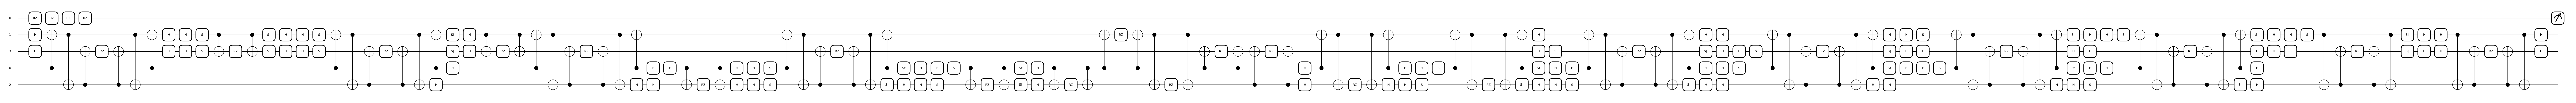

In [35]:
fig, ax =  qml.draw_mpl(circuit_op)(partition_op, 1)
fig.show()
fig.savefig("circuit.pdf")

In [38]:
circuit_op_hand = qml.from_qasm_file("op.cq")
@qml.qnode(dev)
def circuit_hand_on():
    circuit_op_hand(wires=[0,1,2,3 ,4])
    return qml.expval(qml.PauliZ(2))

/Users/hyunseongkim/Documents/공부/.conda/lib/python3.11/site-packages/pennylane_qiskit/converter.py:231: UserWarning: pennylane_qiskit.converter: The Measure instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(
/var/folders/wv/cwvgxcp14lxcs5jn0r6p87sr0000gn/T/ipykernel_22200/161254971.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


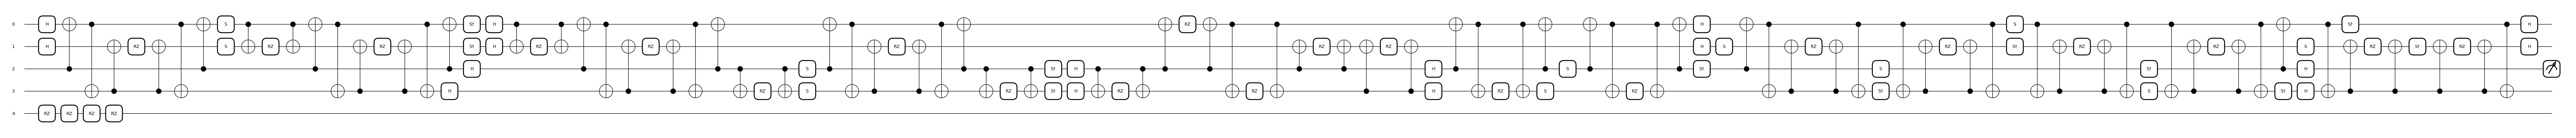

In [39]:
fig, ax =  qml.draw_mpl(circuit_hand_on)()
fig.show()
fig.savefig("circuit2.pdf")

In [40]:
qml.specs(circuit_hand_on)()["resources"]

wires: 5
gates: 137
depth: 107
shots: Shots(total=None)
gate_types:
{'Hadamard': 16, 'CNOT': 74, 'RZ': 25, 'S': 11, 'Adjoint(S)': 11}
gate_sizes:
{1: 63, 2: 74}


/Users/hyunseongkim/Documents/공부/.conda/lib/python3.11/site-packages/pennylane_qiskit/converter.py:231: UserWarning: pennylane_qiskit.converter: The Measure instruction is not supported by PennyLane, and has not been added to the template.
  warnings.warn(
/Users/hyunseongkim/Documents/공부/.conda/lib/python3.11/site-packages/pennylane/gradients/gradient_transform.py:290: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


In [48]:
wires = range(n_wires)
@qml.qnode(dev)
def circuit_evolve(time):
    qml.ApproxTimeEvolution(Hamiltonian, time, 1)
    return [qml.expval(qml.PauliZ(wires=i)) for i in wires]
qml.specs(circuit_evolve, expansion_strategy='device')(1)["resources"]

wires: 4
gates: 270
depth: 169
shots: Shots(total=None)
gate_types:
{'RZ': 106, 'CNOT': 84, 'RX': 80}
gate_sizes:
{1: 186, 2: 84}
